# Analyze Changes
Notebook to measure how Dialogflow NLU model performs on weekly random sample of data. 

At this time, the sample is based off the first user interaction in a session. 

In [15]:
# libraries
import time
import os
import random
import math
import pathlib
import altair as alt
import numpy as np
import pandas as pd
import datetime
from datetime import date
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import ipycytoscape
import ipywidgets as widgets

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from memo import memlist, grid
from pyvis.network import Network
from IPython.core.display import display, HTML
from networkx.algorithms.community import greedy_modularity_communities
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [42]:
def dolores_prep_data(df):
    # filter for only trainable intents
    df = df[df['trainable?'] == 'Yes']
    
    # clean up utterance change column
    df['utterance_change'] = df['utterance_change'].fillna('')
    df['utterance_change'] = [x.strip() for x in df['utterance_change']]
    df['utterance_change'] = [x.lower() for x in df['utterance_change']]
    
    # filter for remove utterance only
    df = df[df['utterance_change'] != 'remove']
    
    # filter for all intents with less than two examples
    intent_count = df.groupby('intentName')['text'].count()
    intent_count = intent_count.reset_index()
    intent_count = intent_count.rename(columns={'text':'count', 'intentName':'label'})
    intent_count = intent_count.set_index('label')
    
    # remove columns and rename column
    cols = ['text','intentName']
    df = df[cols]
    df = df.rename(columns={'intentName':'label'})
    
    # add intent counts
    a = df.set_index('label')
    b = intent_count
    merge = a.merge(b, how='left', left_index=True, right_index=True)
    merge = merge[merge['count'] >= 2]
    
    # remove count column and move label back from index to column
    merge = merge.drop(columns='count')
    merge = merge.reset_index(drop=False)
    
    # convert all text to lower case
    merge['text'] = merge['text'].str.lower()
    
    # remove empty phrases in text
    merge = merge[merge['text'].isnull()!=True]
    
    return merge


def run_tests(X,y):
    skf  = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
    skf.get_n_splits(X,y)
    mod = make_pipeline(CountVectorizer(),
                    LogisticRegression(solver='liblinear', class_weight='balanced'))
    test_num = 1
    k_fold_results = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        mod.fit(X_train, y_train)

        predictions = mod.predict(X_test)

        data = list(zip(X_test, y_test, predictions))
        columns = ['text','actual_intent','pred_intent']
        df_f1 = pd.DataFrame(data, columns=columns)
        df_f1['test_num'] = test_num
        k_fold_results.append(df_f1)

        test_num += 1
    
    all_tests = pd.concat(k_fold_results)
    return all_tests


def build_prediction_matrix(df, predicted_col, actual_col,  ignore_intents=[]):
    '''
    Overview: A function to create a confusion matrix from k-fold cross-validation data
    Input: 
        1. k_fold_data (dataframe): The Dialogflow k-fold test data
    Output:
        1. prediction_maxtrix_df (dataframe): The confusion matrix
    '''
    
    y_true = df[actual_col].values
    y_pred = df[predicted_col].values
    labels_pred = [x for x in np.unique(y_pred)]
    labels_actual = [x for x in np.unique(y_true)]
    labels = list(set(labels_pred+ labels_actual))
    cf_m = confusion_matrix(y_true, y_pred, labels=labels)
    df_cm = pd.DataFrame(cf_m, index=labels, columns=labels)
    #df_cm = df_cm[~df_cm.index.isin(ignore_intents)]
    prediction_maxtrix_df = df_cm.reset_index()
    return prediction_maxtrix_df


def build_true_false_matrix(confusion_matrix_df):
    '''
    Overview: A function to output a confusion matrix with totals and multi-index columns for output
    Input:
        1. confusion_matrix_df (dataframe): A standard confusion matrix created from sklearn.
    Output:
        1. matrix_totals (dataframe)
    '''
    matrix_totals = confusion_matrix_df
    matrix_totals = matrix_totals.set_index('index')
    np.fill_diagonal(matrix_totals.values, 0)
    matrix_totals = matrix_totals.reset_index(drop=False)
    matrix_totals = matrix_totals.rename(columns={'index':'Expected'})
    matrix_totals.loc[:,'FN Total'] = matrix_totals.sum(axis=1)
    header = pd.MultiIndex.from_product([['Actual'],list(matrix_totals.columns)])
    matrix_totals = pd.DataFrame(data=matrix_totals.iloc[:,1:].to_numpy(), index=matrix_totals['Expected'], columns = header[1:])
    matrix_totals.loc['FP Total',:]= matrix_totals.sum(axis=0)
    return matrix_totals


def built_network_graph(df):
    graph_df = df.iloc[:-1, :-1]
    graph_df = graph_df['Actual']
    columns = graph_df.columns.tolist()

    source = []
    target = []
    weight = []

    for index, row in graph_df.iterrows():
        for col in columns:
            if row[col] != 0:
                source.append(index)
                target.append(col)
                weight.append(row[col])

    edge_df = pd.DataFrame(weight, columns=["weight"])
    edge_df['source'] = source
    edge_df['target'] = target
    G = nx.from_pandas_edgelist(edge_df, 'source', "target", ["weight"])
    degrees = nx.degree(G)
    node_size_dict = dict(degrees)
    nx.set_node_attributes(G, node_size_dict, name='size')
    #H = G.to_directed()
    
    from networkx.algorithms.community import greedy_modularity_communities
    communities_generator = greedy_modularity_communities(G, weight='weight', resolution=1)
    #list(communities_generator)
    new_list = []
    for i in range(len(communities_generator)):
        a =  [x for x in communities_generator[i]]
        new_list.append(a)

    get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
    colors = get_colors(len(new_list))
    color_dict = {}
    for i in range(len(new_list)):
        for j in range(len(new_list[i])):
            color_dict[new_list[i][j]] = i+1

    nx.set_node_attributes(G, color_dict, name='group')
    return G


def build_page_rank(graph):
    pagerank = nx.pagerank(graph, weight='weight')
    pagerank_df = pd.DataFrame.from_dict(pagerank, orient='index')
    pagerank_df = pagerank_df.rename(columns={0:'page_rank'})
    return pagerank_df

def degree_list(graph):
    degree = graph.degree()
    degree_list = []
    for (n,d) in degree:
        degree_list.append(d)
    return degree_list

def load_dolores_training_data(new_file_path, old_file_path, new_sheet_name, old_sheet_name):
    # load new data
    df_new = pd.read_excel('data/input/DoloresTraining_Current_4.xlsx', sheet_name='EN locale - Training Queries')
    # load old data
    df_old = pd.read_excel('data/input/DoloresTraining_Current_1.xlsx', sheet_name='EN locale - Training Queries')
    
    df_old2 = dolores_prep_data(df_old)
    df_new2 = dolores_prep_data(df_new)
    X_old = df_old2['text'].values
    y_old = df_old2['label'].values
    X_new = df_new2['text'].values
    y_new = df_new2['label'].values
    
    old_test_results = run_tests(X_old,y_old)
    
    labels_pred=np.unique(old_test_results['pred_intent'])
    labels_actual=np.unique(old_test_results['actual_intent'])
    labels_old = labels_pred + labels_actual
    
    
    old_report_dict = classification_report(old_test_results['actual_intent'], old_test_results['pred_intent'], output_dict=True, labels=labels_old)
    old_result_df = pd.DataFrame(old_report_dict).transpose()
    old_result_df = old_result_df.iloc[:-3]
    
    new_test_results = run_tests(X_new,y_new) 
    
    labels_pred=np.unique(new_test_results['pred_intent'])
    labels_actual=np.unique(new_test_results['actual_intent'])
    labels_new = labels_pred + labels_actual
    
    new_report_dict = classification_report(new_test_results['actual_intent'], new_test_results['pred_intent'], output_dict=True, labels=labels_new)
    new_result_df = pd.DataFrame(new_report_dict).transpose()
    new_result_df = new_result_df.iloc[:-3]
    return df_new, df_old, new_result_df, old_result_df, old_test_results, new_test_results



def load_df_kfold_data(file_path, new_sheet_name, old_sheet_name, predicted_col, actual_col):
    # load new data
    df_new = pd.read_excel(file_path, sheet_name=new_sheet_name)
    df_new = df_new[df_new[actual_col].isnull()==False]
    df_new = df_new[df_new[predicted_col].isnull()==False]
    
    df_new[predicted_col] = df_new[predicted_col].str.lower()
    df_new[actual_col] = df_new[actual_col].str.lower()
           
    df_new[predicted_col] = df_new[predicted_col].str.strip()
    df_new[actual_col ]= df_new[actual_col].str.strip()
           
    # load old data
    df_old = pd.read_excel(file_path, sheet_name=old_sheet_name)
    df_old = df_old[df_old[actual_col].isnull()==False]
    df_old = df_old[df_old[predicted_col].isnull()==False]
    
    df_old[predicted_col] = df_old[predicted_col].str.lower()
    df_old[actual_col] = df_old[actual_col].str.lower()
           
    df_old[predicted_col] = df_old[predicted_col].str.strip()
    df_old[actual_col ]= df_old[actual_col].str.strip()
    
    
    old_test_results = df_old.copy()
    labels_pred=list(np.unique(old_test_results['predicted_intent']))
    labels_actual=list(np.unique(old_test_results['actual_intent']))
    labels_old = list(set(labels_pred + labels_actual))
    
    
    old_report_dict = classification_report(df_old[actual_col], df_old[predicted_col], output_dict=True, labels=labels_old)
    old_result_df = pd.DataFrame(old_report_dict).transpose()
    old_result_df = old_result_df.iloc[:-3]
    
    new_test_results = df_new.copy()
    labels_pred=list(np.unique(new_test_results['predicted_intent']))
    labels_actual=list(np.unique(new_test_results['actual_intent']))
    labels_new = list(set(labels_pred + labels_actual))
    
    
    new_report_dict = classification_report(df_new[actual_col], df_new[predicted_col], output_dict=True, labels=labels_new)
    new_result_df = pd.DataFrame(new_report_dict).transpose()
    new_result_df = new_result_df.iloc[:-3]
    
    return df_new, df_old, new_result_df, old_result_df, old_test_results, new_test_results


def f1_summary(df_new, df_old, new_result_df, old_result_df, pre=False):
    if pre==False:
        columns_vals = ['Dialogflow']
    else:
        columns_vals = ['Simple']
    
    # get f1-score summmary
    #today = date.today()
    #columns_vals = [today]

    new_phrases_total = len(df_new['text'])
    old_phrases_total = len(df_old['text'])
    phrases_diff = new_phrases_total - old_phrases_total

    #old_f1 = round(old_result_df['f1-score'].mean(),2)
    #new_f1 = round(new_result_df['f1-score'].mean(),2)
    old_f1 = round(old_result_df['f1-score'].mean(),4)
    new_f1 = round(new_result_df['f1-score'].mean(),4)

    #old_precision = round(old_result_df['precision'].mean(),2)
    #new_precision = round(new_result_df['precision'].mean(),2)
    old_precision = round(old_result_df['precision'].mean(),4)
    new_precision = round(new_result_df['precision'].mean(),4)

    #old_recall = round(old_result_df['recall'].mean(),2)
    #new_recall = round(new_result_df['recall'].mean(),2)
    old_recall = round(old_result_df['recall'].mean(),4)
    new_recall = round(new_result_df['recall'].mean(),4)
    
    old_fp = old_result_df['FP'].sum()
    new_fp = new_result_df['FP'].sum()
    old_fn = old_result_df['FN'].sum()
    new_fn = new_result_df['FN'].sum()
    old_tp = old_result_df['TP'].sum()
    new_tp = new_result_df['TP'].sum()
    old_tn = old_result_df['TN'].sum()
    new_tn = new_result_df['TN'].sum()
    old_n = old_result_df['N'].sum()
    new_n = new_result_df['N'].sum()
    
    #data = [old_fp, new_fp, old_fn, new_fn, old_tp, new_tp, old_tn, new_tn, old_f1, new_f1, old_precision, new_precision, old_recall, new_recall,  old_phrases_total, new_phrases_total, phrases_diff]
    #cols = ['Old FP', 'New FP', 'Old FN', 'New FN', 'Old TP', 'New TP', 'Old TN', 'New TN', 'Old F1-score','New F1-score', 'Old Precision', 'New Precision', 'Old Recall', 'New Recall','Total Old Phrases','Total New Phrases','Phrases Diff']
    data_1 = [old_fp, old_fn, old_tp, old_tn, old_n, old_f1, old_precision, old_recall, old_phrases_total]
    data_2 = [new_fp, new_fn, new_tp, new_tn, new_n, new_f1, new_precision, new_recall, new_phrases_total]
    cols = ['FP','FN','TP','TN','N','F1-score','Precision','Recall','Phrases']
    
    
    summary_df_1 = pd.DataFrame(data_1, index=cols, columns=['Old'])
    summary_df_2 = pd.DataFrame(data_2, index=cols, columns=['New'])
    
    summary_merge = summary_df_1.merge(summary_df_2, how='inner', left_index=True, right_index=True)
    #summary_df = summary_df.transpose()
    return summary_merge, new_phrases_total, old_phrases_total


#compare before and after
def f1_score_dist_plot(new_result_df, old_result_df, ax, pre=False):
    if pre==False:
        title = 'Old vs New F1-score Distribution'
    else:
        title = 'Old vs New F1-score Distribution'
    
    merge = new_result_df.merge(old_result_df, how='left', left_index=True, right_index=True, suffixes=('_new', '_old'))
    merge['f1-score-diff'] = merge['f1-score_new'] - merge['f1-score_old']
    merge['precision-diff'] = merge['precision_new'] - merge['precision_old']
    merge['recall-diff'] = merge['recall_new'] - merge['recall_old'] 

    cols = ['f1-score_new','f1-score_old']
    data = merge[cols].reset_index()
    #data = data.rename(columns={'index':'intent'})
    data = data.drop(columns=['index'])
    data = data.stack().reset_index(drop=False)
    data = data.drop(columns=['level_0'])
    data = data.rename(columns={'level_1':'new_old', 0:'score'})
    hist_graph = sns.histplot(data=data, x="score", hue="new_old", kde=True, ax=ax).set(title=title)
    return(merge, hist_graph)

def build_subgraph(subgraph):
    degrees = nx.degree(subgraph)
    node_size_dict = dict(degrees)
    nx.set_node_attributes(subgraph, node_size_dict, name='size')
        #H = G.to_directed()
    communities_generator = greedy_modularity_communities(subgraph, weight='weight', resolution=1.75)
    #list(communities_generator)
    new_list = []
    for i in range(len(communities_generator)):
        a =  [x for x in communities_generator[i]]
        new_list.append(a)

    get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
    colors = get_colors(len(new_list))
    #colors = ['red','blue','green','yellow','pink','purple','orange','teal','maroon']
    color_dict = {}
    for i in range(len(new_list)):
        for j in range(len(new_list[i])):
            color_dict[new_list[i][j]] = i+1

    nx.set_node_attributes(subgraph, color_dict, name='group')
    return(subgraph)


def build_cf_counts(confusion_matrix, results_df):
    
    cfm = confusion_matrix.iloc[:,1:]
    FP = cfm.sum(axis=0) - np.diag(cfm) 
    FP = FP.to_numpy()
    
    FN = cfm.sum(axis=1) - np.diag(cfm)
    FN = FN.to_numpy()
    
    TP = np.diag(cfm)
    TN = cfm.values.sum() - (FP + FN + TP)
    
    N = TP + FN
    
    results_df['FP'] = FP
    results_df['FN'] = FN
    results_df['TP'] = TP
    results_df['TN'] = TN
    
    results_df = results_df.rename(columns={'support':'N'})
    
    cols = ['FP','FN','TP','TN','N','precision','recall','f1-score']
    
    return results_df[cols]

### File Inputs

In [40]:
new_transcript_review_dashboard_file = 'Transcript Review Dashboard - 2021 (38).xlsx'
path = 'data/input/'
file_path = path+new_transcript_review_dashboard_file
new_sheet_name = 'NLU - Nov 29th-Dec 5th'
old_sheet_name = 'NLU - November 21-28'

actual_col_name = 'actual_intent'
predicted_col_name = 'predicted_intent'
df_new_k, df_old_k, new_result_df_k, old_result_df_k, old_test_results_k, new_test_results_k  = load_df_kfold_data(file_path, new_sheet_name, old_sheet_name, predicted_col_name, actual_col_name)
new_pred_matrix = build_prediction_matrix(new_test_results_k,  predicted_col_name, actual_col_name)
old_pred_matrix = build_prediction_matrix(old_test_results_k, predicted_col_name, actual_col_name)


new_result_df_k = build_cf_counts(new_pred_matrix, new_result_df_k)
old_result_df_k = build_cf_counts(old_pred_matrix, old_result_df_k)
    
now = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

## F1-Score Changes
+ **F1-score**: Conveys balance between precision and recall. Somewhat of an average between the two. 
+ **Precision**: The fraction of true positive examples among the examples that the model classified as positive.  
 
    + Ex: If a model predicts an apple or orange and it predicts an apple ninety times correctly out of one hundred predictions, the model would have precision score of 90% (90/100 = 90%).
+ **Recall**: The fraction of examples classified as positive, among the total number of positive examples.

    + Ex: If a model predicts an apple or orange, and it predicts an apple eighty times out of one hundred times it could have predicted an apple, the model would have recall score of 80%. (80/100 = 80%). 
+ **High recall, but low precision**: The model is correctly predicting well, but also predicting when it shouldn't.
+ **Low recall, high precision**: The model is missing out on predicting when it should, but when it does predict it tends to do well.
+ **High recall, high precision**: The model is doing a good job. It is predicting when it should and it isn't missing out on predicting.

In [41]:
df_post, new_phrases_total_k, old_phrases_total_k = f1_summary(df_new_k, df_old_k, new_result_df_k, old_result_df_k, pre=False)


new_fn_fp = build_true_false_matrix(new_pred_matrix)
old_fn_fp = build_true_false_matrix(old_pred_matrix)

a_string = "Overall"
print("\033[1m" + a_string + "\033[0m")
display(df_post)

Overall


,Old,New
FP,85.0000,127.0000
FN,85.0000,127.0000
TP,213.0000,397.0000
TN,40741.0000,81617.0000
N,298.0000,524.0000
F1-score,0.3758,0.0000
Precision,0.3554,0.4113
Recall,0.4254,0.4185
Phrases,298.0000,524.0000


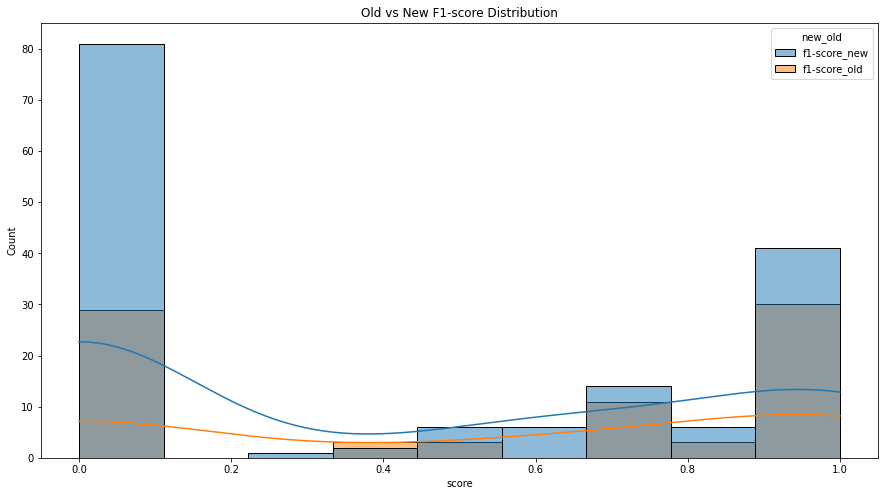

In [19]:
f, (ax1) = plt.subplots(1, 1, sharey=True, figsize = (15,8))
k_merge, k_plot = f1_score_dist_plot(new_result_df_k, old_result_df_k, ax=ax1)

In [20]:
k_desc = k_merge[['FP_new', 'FP_old','FN_new','FN_old','TP_new','TP_old','TN_new','TN_old','f1-score_new','f1-score_old','precision_new', 'precision_old', 'recall_new', 'recall_old']].describe()

mean_score_diff_diaglowflow = k_desc.loc['mean']['f1-score_new'] - k_desc.loc['mean']['f1-score_old']
median_score_diff_diaglowflow = k_desc.loc['50%']['f1-score_new'] - k_desc.loc['50%']['f1-score_old']

twenty_five_score = k_desc.loc['25%']['f1-score_new']
fifty_score = k_desc.loc['50%']['f1-score_new']
seventy_five_score = k_desc.loc['75%']['f1-score_new']

kmerge_display = k_merge[k_merge['N_new'] > 5]

print("Dialogflow F1-score Mean Diff: {}".format(round(mean_score_diff_diaglowflow,4)))
print("Dialogflow F1-score Median Diff: {}".format(round(median_score_diff_diaglowflow,4)))
#print("25% of new Dialogflow F1-scores are below {}".format(round(twenty_five_score,4)))
print("50% of new Dialogflow F1-scores are below  {}".format(round(fifty_score,4)))
#print("75% of new Dialogflow F1-scores are below  {}".format(round(seventy_five_score,4)))
print()
print("Bottom 10 Lowest F1-Scores with More than Five Samples")
display(kmerge_display.sort_values(by=['f1-score_new','N_new', 'FP_new'], ascending=[True, True, False])[0:10])
print()
print("Top 10 Highest F1-Scores with More than Five Samples")
display(kmerge_display.sort_values(by=['f1-score_new', 'N_new'], ascending=[False, False])[0:10])

Dialogflow F1-score Mean Diff: -0.1342
Dialogflow F1-score Median Diff: -0.6667
50% of new Dialogflow F1-scores are below  0.0

Bottom 10 Lowest F1-Scores with More than Five Samples


,FP_new,FN_new,TP_new,TN_new,N_new,precision_new,recall_new,f1-score_new,FP_old,FN_old,TP_old,TN_old,N_old,precision_old,recall_old,f1-score_old,f1-score-diff,precision-diff,recall-diff
rcs.1-rcs_group_entry,0,8,0,516,8.0,0.000000,0.000000,0.000000,0.0,1.0,0.0,297.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
default_fallback,3,18,7,496,25.0,0.700000,0.280000,0.400000,2.0,10.0,5.0,281.0,15.0,0.714286,0.333333,0.454545,-0.054545,-0.014286,-0.053333
no.seller.response,2,3,4,515,7.0,0.666667,0.571429,0.615385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
someone.else.used.account,4,2,5,513,7.0,0.555556,0.714286,0.625000,2.0,1.0,5.0,290.0,6.0,0.714286,0.833333,0.769231,-0.144231,-0.158730,-0.119048
payment.on.hold,1,12,24,487,36.0,0.960000,0.666667,0.786885,1.0,0.0,9.0,288.0,9.0,0.900000,1.000000,0.947368,-0.160483,0.060000,-0.333333
local.pickup,0,1,5,518,6.0,1.000000,0.833333,0.909091,0.0,0.0,1.0,297.0,1.0,1.000000,1.000000,1.000000,-0.090909,0.000000,-0.166667
callme_entry,4,0,20,500,20.0,0.833333,1.000000,0.909091,0.0,1.0,12.0,285.0,13.0,1.000000,0.923077,0.960000,-0.050909,-0.166667,0.076923
help.menu,2,1,16,505,17.0,0.888889,0.941176,0.914286,0.0,0.0,5.0,293.0,5.0,1.000000,1.000000,1.000000,-0.085714,-0.111111,-0.058824
talk_to_human_entry,0,10,124,390,134.0,1.000000,0.925373,0.961240,0.0,3.0,59.0,236.0,62.0,1.000000,0.951613,0.975207,-0.013966,0.000000,-0.026240
smalltalk.greetings.hello,2,1,38,483,39.0,0.950000,0.974359,0.962025,1.0,0.0,26.0,271.0,26.0,0.962963,1.000000,0.981132,-0.019107,-0.012963,-0.025641



Top 10 Highest F1-Scores with More than Five Samples


,FP_new,FN_new,TP_new,TN_new,N_new,precision_new,recall_new,f1-score_new,FP_old,FN_old,TP_old,TN_old,N_old,precision_old,recall_old,f1-score_old,f1-score-diff,precision-diff,recall-diff
smalltalk.appraisal.thank_you,0,0,8,516,8.0,1.000000,1.000000,1.000000,0.0,0.0,2.0,296.0,2.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
smalltalk.confirmation.yes,0,0,6,518,6.0,1.000000,1.000000,1.000000,0.0,0.0,1.0,297.0,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
buying.selling.restricted,1,1,39,483,40.0,0.975000,0.975000,0.975000,2.0,0.0,12.0,284.0,12.0,0.857143,1.000000,0.923077,0.051923,0.117857,-0.025000
smalltalk.greetings.hello,2,1,38,483,39.0,0.950000,0.974359,0.962025,1.0,0.0,26.0,271.0,26.0,0.962963,1.000000,0.981132,-0.019107,-0.012963,-0.025641
talk_to_human_entry,0,10,124,390,134.0,1.000000,0.925373,0.961240,0.0,3.0,59.0,236.0,62.0,1.000000,0.951613,0.975207,-0.013966,0.000000,-0.026240
help.menu,2,1,16,505,17.0,0.888889,0.941176,0.914286,0.0,0.0,5.0,293.0,5.0,1.000000,1.000000,1.000000,-0.085714,-0.111111,-0.058824
callme_entry,4,0,20,500,20.0,0.833333,1.000000,0.909091,0.0,1.0,12.0,285.0,13.0,1.000000,0.923077,0.960000,-0.050909,-0.166667,0.076923
local.pickup,0,1,5,518,6.0,1.000000,0.833333,0.909091,0.0,0.0,1.0,297.0,1.0,1.000000,1.000000,1.000000,-0.090909,0.000000,-0.166667
payment.on.hold,1,12,24,487,36.0,0.960000,0.666667,0.786885,1.0,0.0,9.0,288.0,9.0,0.900000,1.000000,0.947368,-0.160483,0.060000,-0.333333
someone.else.used.account,4,2,5,513,7.0,0.555556,0.714286,0.625000,2.0,1.0,5.0,290.0,6.0,0.714286,0.833333,0.769231,-0.144231,-0.158730,-0.119048


## Undirected Graph Analysis
The confusion matrix of false negatives and false positives is turned into a network graph to analyze the relationships. 

### Confusion Network Structure
Comparing degrees and density gives information about the overall structure of the networks. How similar or different the old confusion matrix is to the new confusion matrix. If the two networks are similar with each other, it usefull to compare them. 

+ **Nodes**: Is an intent in the confusion matrix.
+ **Edges**: Is a connection of two confused intents or two nodes.
    + More edges means more confusion happened overall.
    + Less edges means less confusion happened overall.
+ **Degree**: The number edges that an intent/node has.
    + Small degree means less confusion for the intent.
    + Higher degree means more confusion for the intent.
+ **Average Degree**: Is the average number of edges the intents/nodes have in the network.
    + Smaller average degree means less confusion.
    + Higher average degree more more confusion.
+ **Density**: The portion of the potential connections in a network that are actual connections. 
    + A family reunion would have a lot of actual connections
    + A public bus would have a lot of potential connections
    + Family Reunion: high network density
    + Public Bus: low network density
    + Density helps compare the structure of the two graphs to see how similar they are.
    + https://www.the-vital-edge.com/what-is-network-density/
+ **Connected Components**: A subgraph in which each pair of nodes is connected with each other via a path.
    + https://www.baeldung.com/cs/graph-connected-components
+ **Communities**: 
    + A subset of nodes that are densely connected to each other and loosely connected to the nodes in the other communities in the same graph.
    + [Getting Started with Community Detection in Graphs and Networks](https://www.analyticsvidhya.com/blog/2020/04/community-detection-graphs-networks)
+ **Clique**:
    + A sub-set of a network in which the intents/nodes are more closely and intensely tied to one another than they are to other members of the network.
    + A little more refined subset than a community.
    + [Introduction to social network methods](https://faculty.ucr.edu/~hanneman/nettext/C11_Cliques.html)
    

In [21]:
new_graph = built_network_graph(new_fn_fp)
old_graph = built_network_graph(old_fn_fp)

new_count_nodes = new_graph.number_of_nodes()
old_count_nodes = old_graph.number_of_nodes()
node_diff = old_count_nodes - new_count_nodes 

new_count_edges = new_graph.number_of_edges()
old_count_edges = old_graph.number_of_edges()
edge_diff = new_count_edges - old_count_edges

old_degrees = degree_list(old_graph)
new_degrees = degree_list(new_graph)
new_av_degree = round(sum(new_degrees) / len(new_degrees), 2)
old_av_degree = round(sum(old_degrees) / len(old_degrees), 2)
av_degree_diff = new_av_degree - old_av_degree

old_density = round(nx.density(old_graph),4)
new_density =  round(nx.density(new_graph), 4)
density_diff = old_density - new_density

old_ccs = nx.connected_components(old_graph)
old_cc = max(len(cc) for cc in old_ccs)

new_ccs = nx.connected_components(new_graph)
new_cc = max(len(cc) for cc in new_ccs)

cc_diff = old_cc - new_cc

new_edge_phrase_ratio = round(new_count_edges / new_phrases_total_k, 5)
old_edge_phrase_ratio = round(old_count_edges / old_phrases_total_k, 5)
edge_phrase_ratio_dif = round( new_edge_phrase_ratio - old_edge_phrase_ratio,5)




index_vals = ['new node count', 'old node count', 'node diff', 'new edge count', 'old edge count', 'edge diff', 'new ave degree','old ave degree', 'ave degree diff', 'new density', 'old density', 'density diff', 'old conn comp', 'new conn comp', 'conn comp diff' ]
data = [new_count_nodes, old_count_nodes, node_diff, new_count_edges, old_count_edges, edge_diff, new_av_degree, old_av_degree, av_degree_diff, old_density, new_density, density_diff, new_cc, old_cc, cc_diff]

network_sum_df = pd.DataFrame(data, index = index_vals, columns=['graph structure values'] ).transpose()

groups_dict_all = nx.get_node_attributes(new_graph, name='group')
groups_df_all = pd.DataFrame.from_dict(groups_dict_all, orient='index')
groups_df_all = groups_df_all.rename(columns={0:'communities'})
#groups_df_all = groups_df_all.merge(k_merge, how='left', left_index=True, right_index=True)


nt = Network('1000px', '1000px',  bgcolor='#222222', font_color='white', heading='All Confusion Matrix Graph')
nt.from_nx(new_graph)
nt.show_buttons(filter_=["physics"])
nt.force_atlas_2based(gravity=-603, central_gravity=0.035, spring_length=60, spring_strength=0.03, damping=0.87, overlap=0.8)

path = 'data/output/network_graph/'
file = 'all_new_graph_'+now+".html"
nt.show(path+file)

comm_f1 = groups_df_all.merge(k_merge[['f1-score_new', 'f1-score_old']], how='inner', left_index=True, right_index=True)
comm_f1_mean = comm_f1.groupby('communities').mean()
comm_f1_count = comm_f1.groupby('communities')['f1-score_new'].size()
comm_f1_merge = comm_f1_mean.merge(comm_f1_count, how='inner', left_index=True, right_index=True)
new_names = {'f1-score_new_x':'f1-score_new_mean', 'f1-score_old':'f1-score_old_mean', 'f1-score_new_y':'community size'}
comm_f1_merge = comm_f1_merge.rename(columns=new_names)


print("Old Confusion Ratio:", old_edge_phrase_ratio)
print("New Confusion Ratio:", new_edge_phrase_ratio)
print("Confusion Ratio Diff:", edge_phrase_ratio_dif)
display(network_sum_df)

print()
display(comm_f1_merge)
#display(HTML('html_pages/all_new_graph.html'))

Old Confusion Ratio: 0.26174
New Confusion Ratio: 0.21947
Confusion Ratio Diff: -0.04227


,new node count,old node count,node diff,new edge count,old edge count,edge diff,new ave degree,old ave degree,ave degree diff,new density,old density,density diff,old conn comp,new conn comp,conn comp diff
graph structure values,123.0,104.0,-19.0,115.0,78.0,37.0,1.87,1.5,0.37,0.0146,0.0153,-0.0007,86.0,35.0,-51.0


,f1-score_new_mean,f1-score_old_mean,community size
communities,,,
1,0.235397,0.390909,15
2,0.404547,0.630576,13
3,0.211508,0.555556,12
4,0.304365,0.733802,12
5,0.196296,0.206061,9
6,0.190476,0.333333,7
7,0.461242,0.918360,7
8,0.207483,0.466667,7
9,0.520238,0.555556,4


*Note*
+ *The confusion ratio is calculated by dividing the number total number new edges in the graph (confusion) by the total number of phrases trained.*
+ *Lower the confusion ratio after changes, means the new phrases didn't add a significant amount of confusion.*
+ *New Edge Count = 2829*
+ *New Total Phrases = 19983*
+ *New Edge Count / New Total Phrases = Confusion Ratio*
+ *2829 / 19983 = 0.14157*


*Note*
+ *See file "all_new_graph.html" for visual network graph of the confusion matrix and communities.*

[Text(0.5, 1.0, 'Degree Distribution')]

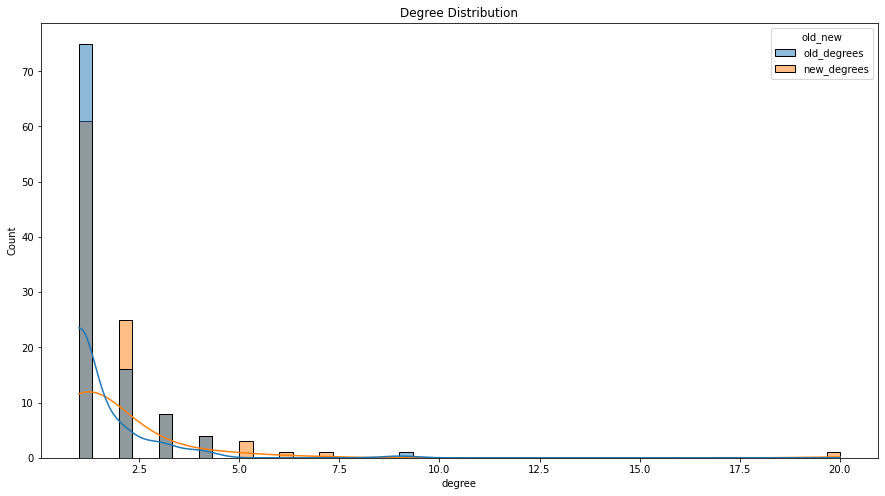

In [22]:
data = list(zip(old_degrees,new_degrees))
data = pd.DataFrame(data, columns=['old_degrees','new_degrees'])
data2 = data.stack().reset_index()
data2= data2.drop(columns=['level_0'])
data2 = data2.rename(columns={'level_1':'old_new', 0:'degree'})
plt.figure(figsize = (15,8))
plot = sns.histplot(data=data2, x="degree", hue='old_new', kde=True).set(title='Degree Distribution')
display(plot)

In [23]:
display(data.describe())

,old_degrees,new_degrees
count,104.000000,104.000000
mean,1.500000,1.913462
std,1.088332,2.150234
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,9.000000,20.000000


### Intent Confusion Influencers
These are intents that if changed, will most likely change network for good or bad. They are usually highly connected and like a hub for the network graph. 

#### Top 10 Page Rank
PageRank assigns a score based on their connections, and their connections’ connections. A similar algorithm that Google used to find important web pages. If a website had more links, it was likely more popular. In our case, it is not good to be popular and have many links. If an intent is popular in this page rank it, got confused a lot. So a high page rank score is bad and low page score is good.

In [24]:
new_page_rank = build_page_rank(new_graph)
old_page_rank = build_page_rank(old_graph)
compare_page_rank = old_page_rank.merge(new_page_rank, how='right', left_index=True, right_index=True, suffixes=('_old', '_new'))
compare_page_rank['page_rank_diff'] = compare_page_rank['page_rank_new'] - compare_page_rank['page_rank_old']


indicies = compare_page_rank.index.values.tolist()

# add degrees: how connected is the node
compare_page_rank['degrees_new'] = [(str(nx.degree(new_graph, x))) for x in indicies]
compare_page_rank['degrees_new'] = compare_page_rank['degrees_new'].replace('[]','0')
compare_page_rank['degrees_new'] = compare_page_rank['degrees_new'].astype(int)

compare_page_rank['degrees_old']  = [str(nx.degree(old_graph, x)) for x in indicies]
compare_page_rank['degrees_old'] = compare_page_rank['degrees_old'].replace('[]','0')
compare_page_rank['degrees_old'] = compare_page_rank['degrees_old'].astype(int)

compare_page_rank['degrees_diff'] = compare_page_rank['degrees_new'] - compare_page_rank['degrees_old'] 

# add clustering: how likely are two nodes connected likely part of a higher connected group or clique
# 0 star, 1 clique
# https://www.youtube.com/watch?v=K2WF4pT5pFY

compare_page_rank['clust_coeff_new'] = [str(nx.clustering(new_graph, x)) for x in indicies]
compare_page_rank['clust_coeff_new'] = compare_page_rank['clust_coeff_new'].replace('{}','0')
compare_page_rank['clust_coeff_new'] = compare_page_rank['clust_coeff_new'].astype(float)

compare_page_rank['clust_coeff_old'] = [str(nx.clustering(old_graph, x)) for x in indicies]
compare_page_rank['clust_coeff_old'] = compare_page_rank['clust_coeff_old'].replace('{}','0')
compare_page_rank['clust_coeff_old'] = compare_page_rank['clust_coeff_old'].astype(float)

compare_page_rank['clust_coeff_diff'] = compare_page_rank['clust_coeff_new'] - compare_page_rank['clust_coeff_old']

# find number of cliques per intent
compare_page_rank['num_of_cliq_new'] = [nx.number_of_cliques(new_graph, x) for x in indicies]
compare_page_rank['num_of_cliq_new'] = compare_page_rank['num_of_cliq_new'].astype(int)

compare_page_rank['num_of_cliq_old'] = [nx.number_of_cliques(new_graph, x) for x in indicies]
compare_page_rank['num_of_cliq_old'] = compare_page_rank['num_of_cliq_old'].astype(int)
page_rank = compare_page_rank[['page_rank_old','page_rank_new','page_rank_diff', 'degrees_new', 'degrees_old']].merge(k_merge[['f1-score_new','f1-score_old']], how='left', left_index=True, right_index=True)
#compare_page_rank

top_page_rank = page_rank.sort_values(by='page_rank_new', ascending=False)[0:10]
cols = ['page_rank_new','page_rank_old','page_rank_diff', 'degrees_new', 'degrees_old', 'f1-score_new','f1-score_old']

print("Top 10 Page Rank Scores")
display(top_page_rank[cols])

Top 10 Page Rank Scores


,page_rank_new,page_rank_old,page_rank_diff,degrees_new,degrees_old,f1-score_new,f1-score_old
default_fallback,0.060737,0.041404,0.019333,20,9,0.400000,0.454545
payment.on.hold,0.038380,0.009615,0.028765,10,1,0.786885,0.947368
talk_to_human_entry,0.024644,0.018449,0.006196,6,3,0.961240,0.975207
rcs.1-rcs_group_entry,0.022658,0.009615,0.013043,7,1,0.000000,0.000000
someone.else.used.account,0.018443,0.014504,0.003939,5,3,0.625000,0.769231
selling,0.018097,0.004376,0.013722,5,1,0.285714,0.000000
inr_entry,0.015170,0.005499,0.009671,4,1,0.000000,0.000000
no.seller.response,0.015037,NaN,NaN,5,0,0.615385,NaN
cnt_entry,0.013047,0.021326,-0.008278,4,3,0.600000,0.363636
ato.transaction,0.013011,0.013868,-0.000857,3,2,0.000000,0.000000


In [25]:
# outputs files

file_name = 'nlu_data_'+now+'.xlsx'

file_path = 'data/output/excel/'

with pd.ExcelWriter(file_path+file_name) as writer: 
    df_post.to_excel(writer, sheet_name='overall_summary', index=True)
    k_merge.to_excel(writer, sheet_name='dialogflow_ml_scores', index=True)
    comm_f1.to_excel(writer, sheet_name='all_network_communities', index=True)
    new_pred_matrix.to_excel(writer, sheet_name='confusion matrix', index=False)
    df_new_k.to_excel(writer, sheet_name='new_data', index=False)
    df_old_k.to_excel(writer, sheet_name='old_data', index=False)
    

In [26]:
%%capture
! jupyter nbconvert nlu_test.ipynb --to=html --TemplateExporter.exclude_input=True

In [27]:
new_html_file_name = 'report_'+now+'.html'
os.rename('nlu_test.html', new_html_file_name)

In [28]:
from pathlib import Path
Path(new_html_file_name).rename("data/output/report/"+new_html_file_name)

WindowsPath('data/output/report/report_2022_03_01_13_25_01.html')